<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/tapi-logo-small.png" />

This notebook free for educational reuse under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/).

Created by [Grant Glass](https://glassgrant.com) for the 2022 Text Analysis Pedagogy Institute, with support from the [National Endowment for the Humanities](https://neh.gov), [JSTOR Labs](https://labs.jstor.org/), and [University of Arizona Libraries](https://new.library.arizona.edu/).

For questions/comments/improvements, email grantg@live.unc.edu<br />
____

# Machine Learning

This is lesson `2` of 3 in the educational series on `Machine Learning`. This notebook is intended `to teach the basics of machine learning and introduce the concepts of:
<br>
1) Applying Machine Learning to Translation<br>
2) Preprocess Text<br>
3) What is a RNN?<br>
4) Looking at different types of ML Models<br> 

**Audience:** `Teachers` / `Learners` / `Researchers`

**Use case:** `Tutorial`

A tutorial is a carefully constructed example that takes the user by the hand through a series of steps to learn how a process works. Tutorials often use "toy" (or at least carefully constrained) examples that give reliable, accurate, and repeatable results every time.

**Difficulty:** `Intermediate`


`Intermediate assumes users are familiar with Python and have been programming for 6+ months. Code makes up a larger part of the notebook and basic concepts related to Python are not explained.`


**Completion time:** `90 minutes`

**Knowledge Required:** 
```
* Python basics (variables, flow control, functions, lists, dictionaries)
* Object-oriented programming (classes, instances, inheritance)
* Regular Expressions (`re`, character classes)

```

**Knowledge Recommended:**
```
* Basic file operations (open, close, read, write)
* Basic Machine Learning Techniques
```

**Learning Objectives:**
After this lesson, learners will be able to:
```
1. Describe and implement a simple RNN
2. Convert words into numbers in order to process text in machine learning.
3. Develop a workflow in order to translate materials into another language. 
4. Be familiar with Machine Learning resources for pursuing the topic
```
**Research Pipeline:**
```
1. Obtain Text and Research Question
2. **The skills in this notebook**
3. Cleaning up data and understanding results
4. Contextualizing results
```
___

# Required Python Libraries
* [Karas](https://keras.io) for deep machine learning.
* [Collections](https://www.geeksforgeeks.org/python-collections-module/) for creating countable dictionaries.
* [NUMPY](https://numpy.org) for calulcating complex equations (like precision and recall)


## Install Required Libraries

In [6]:
# Install software not already available
#!pip install keras

In [7]:
### Install Libraries ###
import collections

import helper
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy


#Ignore warnings = clean notebook
import warnings
warnings.filterwarnings('ignore')

### What are we running this on? Will it take a while? *GPU is fastest

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5032127255643070933
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16139419648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4807869589050183423
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


# Required Data

**Data Title**
* The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file.

**Data Format:** 
* plain txt  (.txt)

**Data Source:**
* [WMT](http://www.statmt.org/)

**Data Quality/Bias:**
`We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from WMT.  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.`

**Data Description:**

`Each line in small_vocab_en contains an English sentence with the respective translation in each line of small_vocab_fr. `

## Loading Required Data

In [9]:
import os
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

In [10]:
# Load English data
english_sentences = load_data('small_vocab_en')
# Load French data
french_sentences = load_data('small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


In [11]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.

## Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary. A more complex vocabulary is a more complex problem. Let's look at the complexity of the dataset we'll be working with.

In [12]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


# Introduction

```

* Why is it useful? 
* Why should we learn it? 
* Who might use it? 
* Where has it been used by scholars/industry?
* What do we need to do it?
* What subjects are included in the notebooks?
* What is not in this notebook? Where should we look for it?
```

In [13]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    words_token = tokenizer.texts_to_sequences(x)
    
    return words_token, tokenizer


# Tokenize Example output
text_sentences = [
    'The quick red fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'red': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick red fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [14]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    
    pad_sentences = pad_sequences(x, maxlen=length, padding='post')
    return pad_sentences


# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [15]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


##What is a Recurrent Neural Network?

A Recurrent Neural Network is a type of neural network that contains loops, allowing information to be stored within the network. In short, Recurrent Neural Networks use their reasoning from previous experiences to inform the upcoming events.

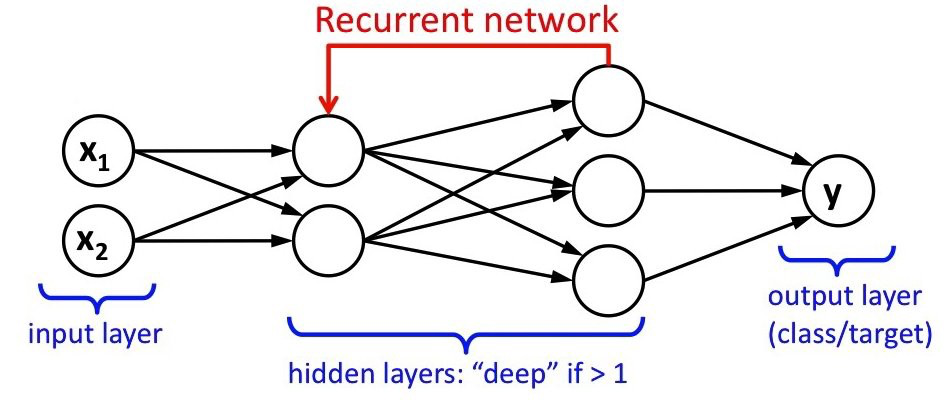



How do Recurrent Neural Networks work?

Recurrent Neural Networks can be thought of as a series of networks linked together. They often have a chain-like architecture, making them applicable for tasks such as speech recognition, language translation, etc. An RNN can be designed to operate across sequences of vectors in the input, output, or both. For example, a sequenced input may take a sentence as an input and output a positive or negative sentiment value. Alternatively, a sequenced output may take an image as an input, and produce a sentence as an output.


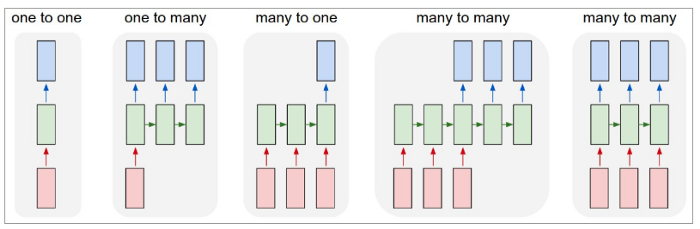

Let's imagine training a RNN to the word "happy," given the letters "h, a, p, y." The RNN will be trained on four separate examples, each corresponding to the likelihood that letters will fall into an intended sequence. For example, the network will be trained to understand the probability that the letter "a" should follow in the context of "h." Similarly, the letter "p" should appear after sequences of "ha." Again, a probability will be calculated for the letter "p" following the sequence "hap." The process will continue until probabilities are calculated to determine the likelihood of letters falling into the intended sequence. So, as the network receives each input, it will determine the probability of the subsequent letter based on the probability of the previous letter or sequence. Over time, the network can be updated to more accurately produce results.



## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN


### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [16]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN

A basic RNN model is a good baseline for sequence data. In this model, you'll build a RNN that translates English to French.


In [17]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """

   
    inp = Input(shape=input_shape[1:])
    rnn = GRU(units=english_vocab_size, return_sequences=True)(inp)
    units = TimeDistributed(Dense(units=french_vocab_size))(rnn)
    model = Model(inp, Activation('softmax')(units))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(0.005),
                  metrics=['accuracy'])
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Epoch 1/10
108/108 [==============================] - 8s 20ms/step - loss: 1.9046 - accuracy: 0.5558 - val_loss: nan - val_accuracy: 0.6220
Epoch 2/10
108/108 [==============================] - 2s 16ms/step - loss: 1.2486 - accuracy: 0.6445 - val_loss: nan - val_accuracy: 0.6615
Epoch 3/10
108/108 [==============================] - 2s 16ms/step - loss: 1.1064 - accuracy: 0.6639 - val_loss: nan - val_accuracy: 0.6683
Epoch 4/10
108/108 [==============================] - 2s 16ms/step - loss: 1.0324 - accuracy: 0.6739 - val_loss: nan - val_accuracy: 0.6858
Epoch 5/10
108/108 [==============================] - 2s 17ms/step - loss: 0.9842 - accuracy: 0.6814 - val_loss: nan - val_accuracy: 0.6880
Epoch 6/10
108/108 [==============================] - 2s 16ms/step - loss: 0.9515 - accuracy: 0.6879 - val_loss: nan - val_accuracy: 0.6952
Epoch 7/10
108/108 [==============================] - 2s 16ms/step - loss: 0.9229 - accuracy: 0.6952 - val_loss: nan - val_accuracy: 0.7027
Epoch 8/10
108/108 [

### Model 2: Embedding

You've turned the words into ids, but there's a better representation of a word. This is called word embeddings. An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.
In this model, you'll create a RNN model using embedding.

In [18]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    
    inp = Input(shape=input_shape[1:])
    embed = Embedding(input_dim=english_vocab_size, output_dim=100, input_length=input_shape[1:][0])(inp)
    rnn = GRU(units=english_vocab_size, dropout=0.05, return_sequences=True)(embed)
    units = TimeDistributed(Dense(units=french_vocab_size))(rnn)
    model = Model(inp, Activation('softmax')(units))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(0.005),
                  metrics=['accuracy'])
    return model



tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))
# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)
                      
embed_rnn_model.summary()

embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)
                      
# TODO: Print prediction(s)

print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 100)           20000     
                                                                 
 gru_1 (GRU)                 (None, 21, 200)           181200    
                                                                 
 time_distributed_1 (TimeDis  (None, 21, 345)          69345     
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, 21, 345)           0         
                                                                 
Total params: 270,545
Trainable params: 270,545
Non-trainable params: 0
_____________________________________________________

### Model 3: Bidirectional RNNs

One restriction of a RNN is that it can't see the future input, only the past. This is where bidirectional recurrent neural networks come in. They are able to see the future data.

In [19]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """

    inp = Input(shape=input_shape[1:])
    rnn = Bidirectional(GRU(units=english_vocab_size, return_sequences=True, go_backwards=True))(inp)
    units = TimeDistributed(Dense(units=french_vocab_size))(rnn)
    model = Model(inp, Activation('softmax')(units))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(0.005),
                  metrics=['accuracy']) 
    
    return model


# Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)



print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))


#embed_rnn_model = embed_model(
    #tmp_x.shape,
    #preproc_french_sentences.shape[1],
    #len(english_tokenizer.word_index)+1,
    #len(french_tokenizer.word_index)+1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 21, 100)           20000     
                                                                 
 gru_2 (GRU)                 (None, 21, 200)           181200    
                                                                 
 time_distributed_2 (TimeDis  (None, 21, 345)          69345     
 tributed)                                                       
                                                                 
 activation_2 (Activation)   (None, 21, 345)           0         
                                                                 
Total params: 270,545
Trainable params: 270,545
Non-trainable params: 0
_____________________________________________________

# Questions and Errors
`Please Share any questions or troubles you have with the code in this google document`
https://docs.google.com/document/d/10XQ9zn_IEQDWKq65LK9rUatvwZliTw71pTh1vXBYMF8/edit?usp=sharing



# Living Bilbiography


https://docs.google.com/document/d/13iyDS6R3keRxyJTrFOD42As6rEOg8vIdnhXyN21A6z4/edit?usp=sharing

# Next Lesson



___
[Proceed to next lesson: Course Machine Learning 3/3 ->](./day3_intro_to_ml.ipynb)